## CMV RNA-seq & ChIP seq - Integrative analysis

In [1]:
import sys
sys.path.append('/Users/erankotler/Google Drive/workspace/CMV2020')
import pandas as pd
import os
from matplotlib import pyplot as plt
from scipy import stats
from statsmodels.stats import multitest
from TSS_signal_vs_RNA_exp import *
from data_manipulations import standardize_df
import seaborn as sns
from graphic_funcs import two_var_bar_graph, bar_graph, norm_dist_fit_hist
%matplotlib inline

In [2]:
output_analysis_dir = "/Users/erankotler/Google Drive/workspace/CMV2020/ChIP_vs_Exp_output"
ChIP_data_dir = "/Users/erankotler/Google Drive/workspace/CMV2020/Data/ChIPseq"
RNAseq_data_dir = "/Users/erankotler/Google Drive/workspace/CMV2020/Data/RNAseq"

TSS_means_file = "IE1_norm_dCTD_All_TSS_500bp_sorted_win_means.csv" # dCTD-normalized data
# IE1_signal = "IE1_output_All_TSS_500bp_sorted_win_means.csv" 
# IE1d_signal = "IE1_dCTD_output_All_TSS_500bp_sorted_win_means.csv"

TPM_file = os.path.join(RNAseq_data_dir, "TPMs_kallisto.tsv")
DE_file = os.path.join(RNAseq_data_dir, "de_stats.csv")

# Noam_RNAseq_data_dir = "/Users/erankotler/Google Drive/workspace/CMV/Data/Stern_Ginnosar_data" # Noam's paper data
# exp_file = os.path.join(Noam_RNAseq_data_dir, "S1_table_RPKM_hg19.xlsx") # data from Noam Stern-Ginnosar's paper

In [24]:
old_cmap = sns.cubehelix_palette(light=1, as_cmap=True)

### Organize gene names in expression data, save to csv
(Need to run only once)

In [3]:
## Organize TPM data (convert names, etc)

# from pyensembl import EnsemblRelease
# data = EnsemblRelease(77) # release 77 uses human reference genome GRCh38

# def get_name(ensembl):
#     return data.gene_name_of_gene_id(ensembl)

# tpm_df = pd.read_csv(TPM_file, sep=' ')
# tpm_df = tpm_df[tpm_df.drop("Gene", axis=1).max(axis=1)>0]
# for i in tpm_df.index:
#     ensembl = tpm_df["Gene"][i]
#     try: 
#         name = get_name(ensembl)
#     except:
#         name = "Unknown"
        
#     tpm_df.loc[i, "Gene_name"] = name

# tpm_df.index = tpm_df["Gene_name"]
# tpm_df.to_csv(os.path.join(output_analysis_dir, "tpm_df.csv"))

### Load and merge datasets:

In [4]:
# Load RNAseq TPM data (organized):
tpm_df = pd.read_csv(os.path.join(output_analysis_dir, "tpm_df.csv"), index_col=0)
# tpm_df = tpm_df[tpm_df["Gene_name"]!="Unknown"] # remove genes with unkown name

In [5]:
# Load and organize ChIP data:
chip_df = pd.read_csv(os.path.join(ChIP_data_dir, TSS_means_file), index_col=0, header=None)
chip_df.columns = ["Signal"]
chip_df.index.name="Gene"

In [6]:
# Merge and drop rows with no expression data:    
df = chip_df.join(tpm_df)
df.dropna(inplace=True)

In [7]:
# Load and merge RNAseq DE data:
de_df = pd.read_csv(DE_file)#, index_col=0) # differential expression data
df = pd.merge(left = df, right = de_df, on='Gene')
df.index = df["Gene_name.1"]

### Data organization and standardization:
Dropping duplicate transcripts; Converting binding data into Z-scores

In [8]:
# Convert ChIP binding scores to Z-scores
df = standardize_df(df, column="Signal")

# # Drop duplicate genes, leaving the row with the more extreme ChIP signal (highest Z score absoulte value)
# df["abs_Signal"] = np.absolute(df["Signal"])
# df= df.sort_values(by="abs_Signal").drop_duplicates(subset='Gene', keep='last') # drop duplicated genes (keep high abs)
# df.drop("abs_Signal", axis=1, inplace=True)

# Drop duplicate genes, leaving the row with the higher ChIP signal (asuming binding and not depletion has an effect):
df= df.sort_values(by="Signal").drop_duplicates(subset='Gene', keep='last') # drop duplicated genes (keep high)

In [9]:
# Expression columns' names:
exp_cols = ['1_Luc_Mock', '2_Luc_Mock', '3_Luc_Mock',              # No-infection mock controls
            '4_Luc_CMV',  '5_Luc_CMV', '6_Luc_CMV',                # Infected with CMV with no IE1
            '7_IE1wt_CMV', '8_IE1wt_CMV', '9_IE1wt_CMV',           # Infected with CMV with wtIE1
            '10_IE1dCTD_CMV', '11_IE1dCTD_CMV', '12_IE1dCTD_CMV']  # Infected with CMV with IE1dCTD

# Add mean expression columns:
df["IE1_mean"] = df[['7_IE1wt_CMV', '8_IE1wt_CMV','9_IE1wt_CMV']].mean(axis=1)
df["IE1dCTD_mean"] = df[['10_IE1dCTD_CMV', '11_IE1dCTD_CMV','12_IE1dCTD_CMV']].mean(axis=1)
df["Luc_mean"] = df[['4_Luc_CMV','5_Luc_CMV', '6_Luc_CMV']].mean(axis=1)
df["Mock_mean"] = df[['1_Luc_Mock', '2_Luc_Mock', '3_Luc_Mock']].mean(axis=1)

In [10]:
# Fill zeros in entire dataset by adding lowest non-zero expression value to entire dataset
vals = df[["IE1_mean", "IE1dCTD_mean", "IE1dCTD_mean", "Luc_mean", "Mock_mean"]].values.flatten()
vals.sort()
sorted_un_vals = np.unique(vals)
min_non0 = sorted_un_vals[1] if sorted_un_vals[0]==0 else sorted_un_vals[0] # minimal no-zero value

if sorted_un_vals[0]==0:
    df[exp_cols] = df[exp_cols] + (min_non0/10.)

# adj_means = df[["IE1_mean", "IE1dCTD_mean", "IE1dCTD_mean", "Luc_mean", "Mock_mean"]].replace(to_replace=0, value=min_non0)
# df[["IE1_mean", "IE1dCTD_mean", "IE1dCTD_mean", "Luc_mean", "Mock_mean"]]=adj_means
# adj_exp_vals = df[exp_cols].replace(to_replace=0, value=min_non0)
# df[exp_cols]=adj_exp_vals

In [18]:
# Add log-expression columns ############***********Decide on log-transformation....
log_exp_cols = [s+"_log" for s in exp_cols]
df[log_exp_cols] = df[exp_cols].apply(lambda v: np.log10(v))

In [19]:
# Add log-mean expression columns
df["IE1_Logmean"] = np.log10(df["IE1_mean"]+1)
df["IE1dCTD_Logmean"] = np.log10(df["IE1dCTD_mean"]+1)
df["Luc_Logmean"] = np.log10(df["Luc_mean"]+1)
df["Mock_Logmean"] = np.log10(df["Mock_mean"]+1)
log_mean_exp_cols = ["IE1_Logmean", "IE1dCTD_Logmean", "Luc_Logmean", "Mock_Logmean"]

/Users/erankotler/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3267: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


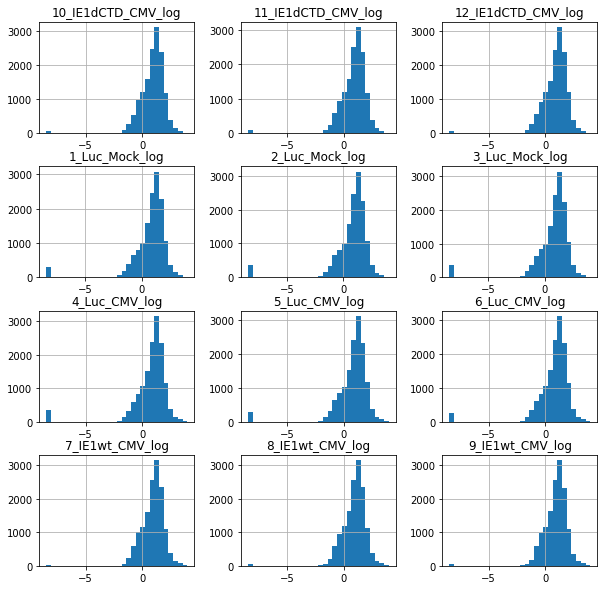

In [20]:
f, ax = plt.subplots(figsize=(10,10))
df[log_exp_cols].hist(bins=30, ax=ax)
plt.show()

### Filter human genes only -> no need because already filtered by merging with ChIP data

In [16]:
# # Filter human genes only (no need because already filtered by merging with ChIP data):
# hs_gene_names_f = "/Users/erankotler/Google Drive/workspace/CMV/Data/Human_genome/enembl_mart_export_GRCh38.txt"
# hs_genes = pd.read_csv(hs_gene_names_f)
# hs_genes = hs_genes.drop_duplicates("Gene stable ID")
# merged = pd.merge(left=df, right=hs_genes, left_on="Gene", right_on="Gene stable ID", how="left")
# print len(df), len(merged), len(hs_genes)

### Correlations between expression levels across samples

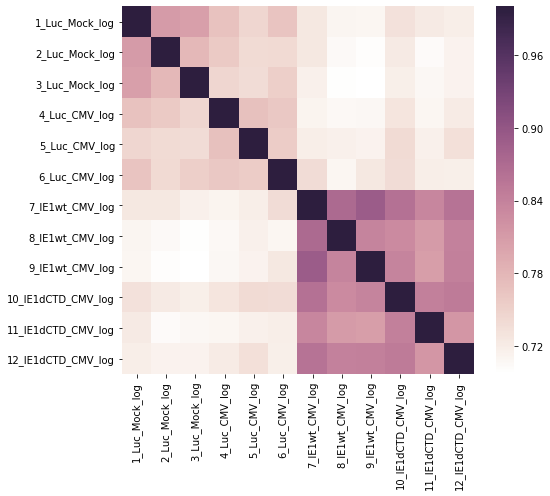

In [25]:
f, ax = plt.subplots(figsize=(8,7))
hm = sns.heatmap(df[log_exp_cols].corr(), ax=ax, cmap=old_cmap)
plt.tight_layout()
plt.savefig(os.path.join(output_analysis_dir,"Intersample_correlations.png"), dpi=300)
plt.show()

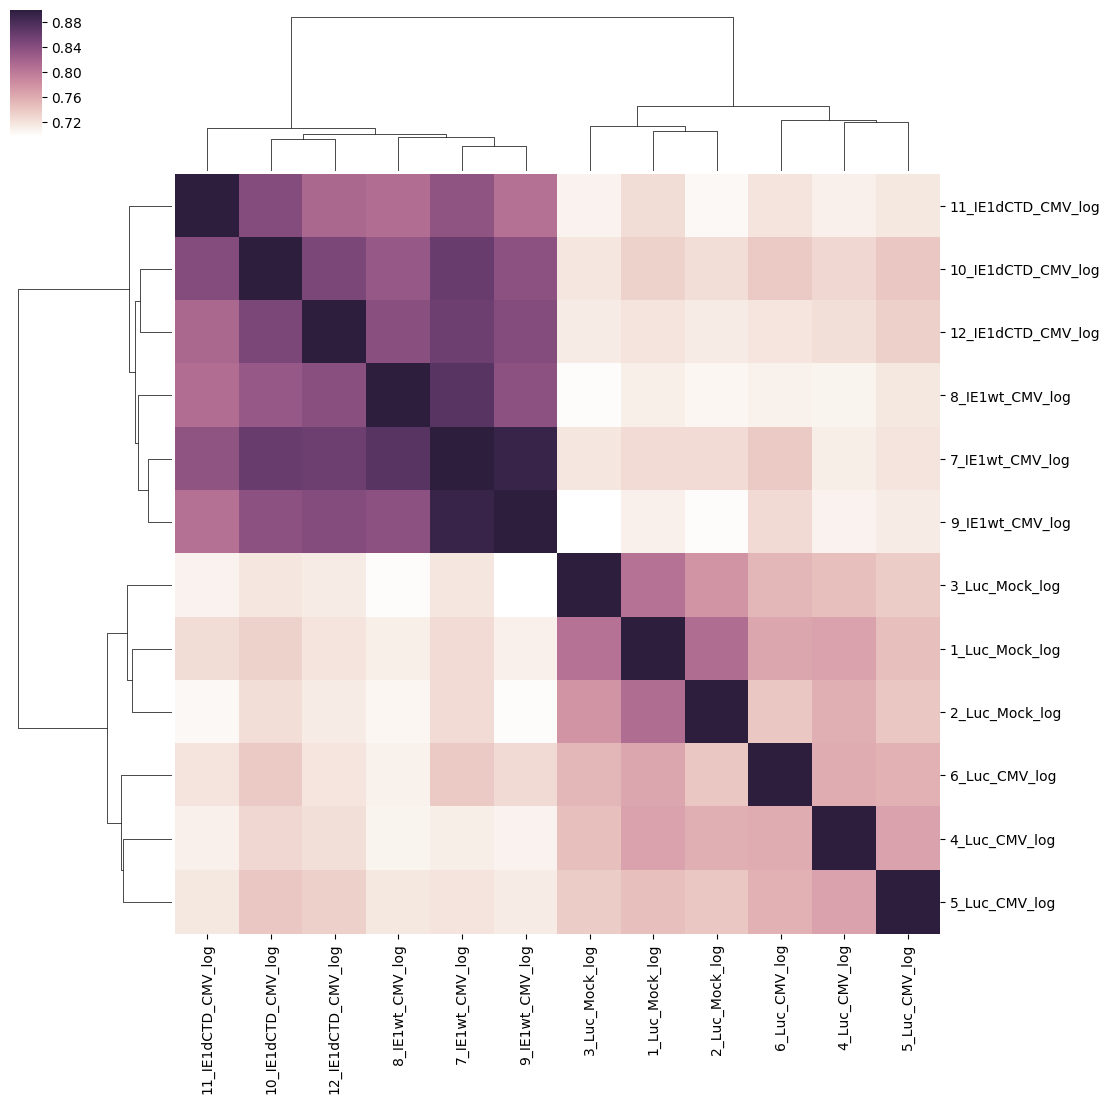

In [40]:
hm = sns.clustermap(df[log_exp_cols].corr(), method='ward', figsize=(12,12), vmax=0.90,
                    cmap=old_cmap) 
hm.ax_heatmap.set_ylabel("")
plt.setp(hm.ax_heatmap.get_yticklabels(), rotation=0)
hm.savefig(os.path.join(output_analysis_dir,"Intersample_correlations_clust.png"), dpi=900)
hm.savefig(os.path.join(output_analysis_dir,"Intersample_correlations_clust.pdf"), dpi=900)

plt.show()

/Users/erankotler/anaconda/lib/python2.7/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


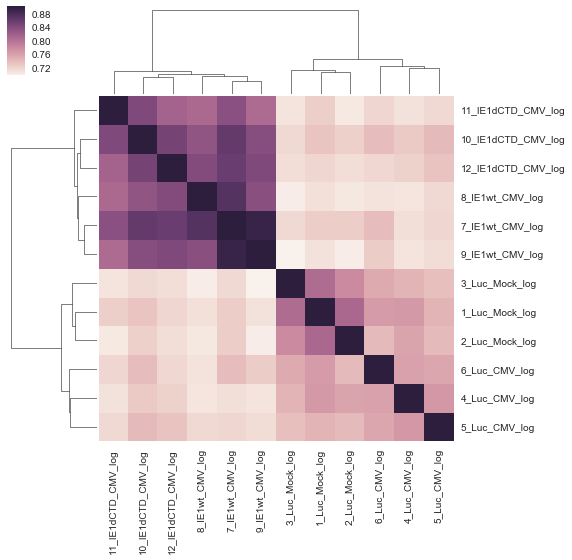

In [18]:
### ORIGINAL
# hm = sns.clustermap(df[log_exp_cols].corr(), method='ward', figsize=(8,8), vmax=0.90)# 
# hm.ax_heatmap.set_ylabel("")
# plt.setp(hm.ax_heatmap.get_yticklabels(), rotation=0)
# plt.savefig(os.path.join(output_analysis_dir,"Intersample_correlations_clust.png"), dpi=300)
# plt.show()

### PCA analysis for samples

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
n_components=3
X = df[log_exp_cols].transpose() # transpose to get PCA for samples rather than genes.
X_std = StandardScaler().fit_transform(X)  # Standartizing values

pca = PCA(n_components=n_components) # Initialize PCA 
X_std_pca = pca.fit_transform(X_std)  # perform pca on standarised data

pca_trans = pd.DataFrame(X_std_pca, columns=['PC %i' % i for i in range(1, n_components+1)], index=X.index)
exp_variances = pca.explained_variance_ratio_

pca_trans = pd.DataFrame(pca.transform(X), columns=['PC %i' % i for i in range(1, n_components+1)], index=X.index)
pca_trans.loc[pca_trans.index[0:3], "Group"]="Luc_Mock"
pca_trans.loc[pca_trans.index[3:6], "Group"]="Luc_CMV"
pca_trans.loc[pca_trans.index[6:9], "Group"]="IE1wt_CMV"
pca_trans.loc[pca_trans.index[9:12], "Group"]="IE1dCTD_CMV"
pca_trans.loc[pca_trans.index[0:3], "Color"]="g"
pca_trans.loc[pca_trans.index[3:6], "Color"]="k"
pca_trans.loc[pca_trans.index[6:9], "Color"]="b"
pca_trans.loc[pca_trans.index[9:12], "Color"]="r"

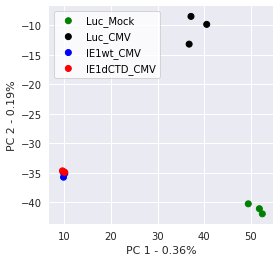

In [20]:
f,ax = plt.subplots(figsize=(4,4))
sns.reset_defaults()

for g in pca_trans["Group"].unique():
    ax.scatter(x=pca_trans.loc[pca_trans["Group"]==g, 'PC 1'], 
               y=pca_trans.loc[pca_trans["Group"]==g, 'PC 2'], 
               c=pca_trans.loc[pca_trans["Group"]==g, "Color"],
               label = g)
ax.legend()
ax.set_xlabel("PC 1 - " + str(exp_variances[0])[0:4] +'%')
ax.set_ylabel("PC 2 - " + str(exp_variances[1])[0:4] +'%')
plt.show()

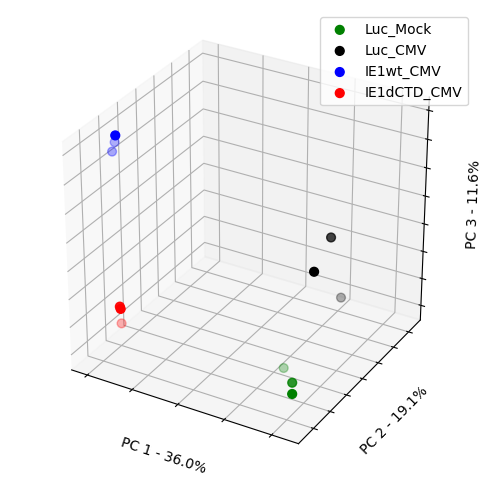

In [39]:
# NEW VERSION 2020
from mpl_toolkits.mplot3d import Axes3D
sns.reset_defaults()

fig = plt.figure(figsize=[6,6])
ax = fig.add_subplot(111, projection='3d')
for g in pca_trans["Group"].unique():
    ax.scatter(xs=pca_trans.loc[pca_trans["Group"]==g, 'PC 1'], 
               ys=pca_trans.loc[pca_trans["Group"]==g, 'PC 2'],
               zs=pca_trans.loc[pca_trans["Group"]==g, 'PC 3'],
               c=pca_trans.loc[pca_trans["Group"]==g, "Color"],
               label = g, s=40)
    
ax.legend()
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.set_xlabel("PC 1 - " + str(100*exp_variances[0])[0:4] +'%')
ax.set_ylabel("PC 2 - " + str(100*exp_variances[1])[0:4] +'%')
ax.set_zlabel("PC 3 - " + str(100*exp_variances[2])[0:4] +'%')
plt.savefig(os.path.join(output_analysis_dir,"PCA_logExpVals.png"), dpi=900)
plt.savefig(os.path.join(output_analysis_dir,"PCA_logExpVals.pdf"), dpi=900)

plt.show()

### Box plots comparing ChIP signal in TSSs of genes on both extremes of each PC
(Comparing the top [num_genes] genes on each end)

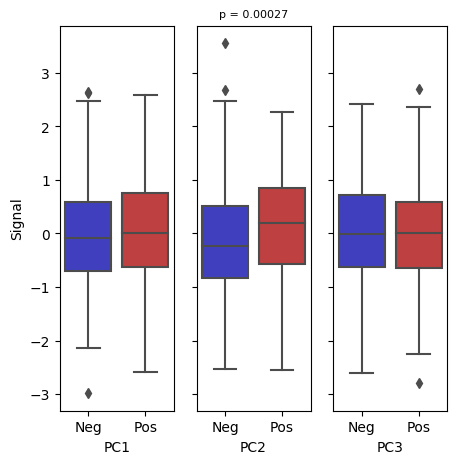

In [42]:
# New version 2020
comps = pd.DataFrame(pca.components_ , columns=X.columns)
PCs = ["PC1", "PC2", "PC3"]
num_genes = 300

PC_comps = comps.transpose()
PC_comps.columns = PCs
j = df.join(PC_comps)

f,axs = plt.subplots(ncols=len(PCs), nrows=1, figsize=(5,5), sharey=True)
for i, PC in enumerate(PCs):
    ext_genes_dfs=[]
    sorted_pc_genes = j.sort_values(by = PC) # sort genes by position along the principal component
    ext_genes_dfs.append(pd.DataFrame(sorted_pc_genes["Signal"].head(num_genes))) # Get extreme negatives
    ext_genes_dfs[-1].loc[:,"Group"] = PC + "_neg"
    ext_genes_dfs[-1].to_csv(os.path.join(output_analysis_dir,PC + "_neg_ext_PCgenes.csv")) # Save gene list
    
    ext_genes_dfs.append(pd.DataFrame(sorted_pc_genes["Signal"].tail(num_genes))) # get extreme positives
    ext_genes_dfs[-1].loc[:,"Group"] = PC + "_pos"
    ext_genes_dfs[-1].to_csv(os.path.join(output_analysis_dir,PC + "_pos_ext_PCgenes.csv")) # Save gene list

    box_grps = pd.concat(ext_genes_dfs)    
    sns.boxplot(x = "Group", y="Signal", data = box_grps, ax=axs[i], palette=['b','r'], saturation=0.5)
    axs[i].set_ylabel('')
    axs[i].set_xlabel(PC)
    axs[i].set_xticklabels(['Neg','Pos'])
    p = stats.mannwhitneyu(ext_genes_dfs[0]["Signal"], ext_genes_dfs[1]["Signal"])[1]
    if p<0.05:
        axs[i].set_title('p = ' + str(p)[:7], fontsize=8)

axs[0].set_ylabel('Signal')
plt.savefig(os.path.join(output_analysis_dir,"Boxs_Signal_of_extreme_PCgenes.png"), dpi=900)
plt.savefig(os.path.join(output_analysis_dir,"Boxs_Signal_of_extreme_PCgenes.pdf"), dpi=900)

plt.show()

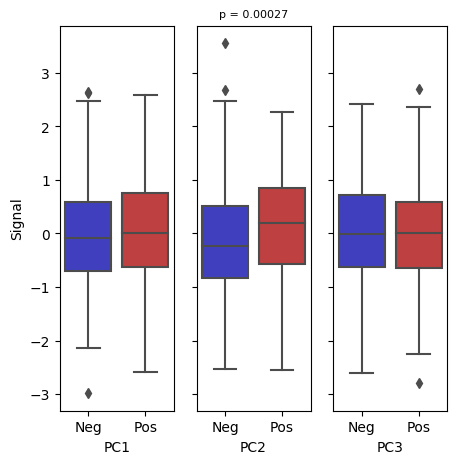

In [41]:
comps = pd.DataFrame(pca.components_ , columns=X.columns)
PCs = ["PC1", "PC2", "PC3"]
num_genes = 300

PC_comps = comps.transpose()
PC_comps.columns = PCs
j = df.join(PC_comps)

f,axs = plt.subplots(ncols=len(PCs), nrows=1, figsize=(5,5), sharey=True)
for i, PC in enumerate(PCs):
    ext_genes_dfs=[]
    sorted_pc_genes = j.sort_values(by = PC) # sort genes by position along the principal component
    ext_genes_dfs.append(pd.DataFrame(sorted_pc_genes["Signal"].head(num_genes))) # Get extreme negatives
    ext_genes_dfs[-1].loc[:,"Group"] = PC + "_neg"
    ext_genes_dfs[-1].to_csv(os.path.join(output_analysis_dir,PC + "_neg_ext_PCgenes.csv")) # Save gene list
    
    ext_genes_dfs.append(pd.DataFrame(sorted_pc_genes["Signal"].tail(num_genes))) # get extreme positives
    ext_genes_dfs[-1].loc[:,"Group"] = PC + "_pos"
    ext_genes_dfs[-1].to_csv(os.path.join(output_analysis_dir,PC + "_pos_ext_PCgenes.csv")) # Save gene list

    box_grps = pd.concat(ext_genes_dfs)    
    sns.boxplot(x = "Group", y="Signal", data = box_grps, ax=axs[i], palette=['b','r'], saturation=0.5)
    axs[i].set_ylabel('')
    axs[i].set_xlabel(PC)
    axs[i].set_xticklabels(['Neg','Pos'])
    p = stats.mannwhitneyu(ext_genes_dfs[0]["Signal"], ext_genes_dfs[1]["Signal"])[1]
    if p<0.05:
        axs[i].set_title('p = ' + str(p)[:7], fontsize=8)

axs[0].set_ylabel('Signal')
plt.savefig(os.path.join(output_analysis_dir,"Boxs_Signal_of_extreme_PCgenes.png"), dpi=300)

plt.show()

In [23]:
pc2_idxs = pd.read_csv(os.path.join(output_analysis_dir,"PC2_pos_ext_PCgenes.csv")).index
pc2_pos_genes = df.ix[pc2_idxs]

### Expression data Heatmap

In [13]:
d = df.loc[df["pass"]=='yes', :]
d = d.drop_duplicates()
d = d.sort_values(by="Gene")
hm_d = d[log_exp_cols]

### NEW ATTEMP 5.7.18 ******

In [ ]:
# Slice de_df by significant diff exp in each comparison. Intersect to extract the genes with the interesting patterns.


In [23]:
exp_d = df.loc[df["pass"]=='yes', :].copy()
exp_d.sort_values(by="Gene", inplace=True)
exp_d.shape

(762, 43)

In [31]:
de_df.loc[de_df["pass"]=='yes', :].shape

(5952, 9)

In [24]:
exp_d.head()

,Signal,Gene,1_Luc_Mock,10_IE1dCTD_CMV,11_IE1dCTD_CMV,12_IE1dCTD_CMV,2_Luc_Mock,3_Luc_Mock,4_Luc_CMV,5_Luc_CMV,...,7_IE1wt_CMV_log,8_IE1wt_CMV_log,9_IE1wt_CMV_log,10_IE1dCTD_CMV_log,11_IE1dCTD_CMV_log,12_IE1dCTD_CMV_log,IE1_Logmean,IE1dCTD_Logmean,Luc_Logmean,Mock_Logmean
Gene_name.1,,,,,,,,,,,,,,,,,,,,,
CFTR,0.505636,ENSG00000001626,1.568577,0.922637,0.453324,0.296731,1.035931,1.189842,0.655552,0.642348,...,-0.566437,-0.338976,-0.055904,-0.034969,-0.343591,-0.527637,0.186462,0.192446,0.268070,0.355027
WNT16,1.785838,ENSG00000002745,4.751430,0.619864,0.945710,1.200965,4.942170,5.535300,2.564938,2.622775,...,0.123710,0.220071,0.089970,-0.207704,-0.024242,0.079530,0.381392,0.283794,0.575974,0.783639
TMEM176A,0.252806,ENSG00000002933,84.313392,24.945448,23.096597,24.076915,84.770457,88.757008,62.818387,61.239389,...,1.619400,1.615223,1.657580,1.396991,1.363548,1.381601,1.641193,1.398628,1.819448,1.939254
PDK4,-0.210169,ENSG00000004799,1.406990,0.795873,0.852448,0.926901,1.691690,1.613590,5.779980,4.923920,...,0.304973,0.339318,0.251081,-0.099156,-0.069332,-0.032967,0.476410,0.269141,0.814612,0.410061
PRKAR2B,-0.475649,ENSG00000005249,12.232800,6.779320,6.555310,6.968090,12.184300,14.149800,14.397500,14.030300,...,0.933789,0.869530,0.938036,0.831186,0.816593,0.843114,0.964753,0.890285,1.193302,1.141626


In [19]:
d.iloc[1,:]

Signal                                1.78584
Gene                          ENSG00000002745
1_Luc_Mock                            4.75143
10_IE1dCTD_CMV                       0.619864
11_IE1dCTD_CMV                        0.94571
12_IE1dCTD_CMV                        1.20097
2_Luc_Mock                            4.94217
3_Luc_Mock                             5.5353
4_Luc_CMV                             2.56494
5_Luc_CMV                             2.62278
6_Luc_CMV                             3.11272
7_IE1wt_CMV                           1.32957
8_IE1wt_CMV                           1.65986
9_IE1wt_CMV                           1.23018
Gene_name.1                             WNT16
Comparison            IE1dCTD_CMV_vs_Luc_Mock
baseMean                                 79.9
log2FoldChange                         -2.523
FoldChange                               -5.7
pvalue                               6.31e-36
padj                                 9.77e-35
pass                              

### END OF NEW ATTEMP 5.7.18 ******

In [26]:
# # Heatmap, sorted by ChIP signal:
# sig_hm.sort_values(by="Signal", inplace=True)
# hm_d = hm_d.ix[sig_hm.index]

# cg = sns.clustermap(hm_d, vmin=vmn, vmax=vmx, cmap='coolwarm', col_cluster=False, row_cluster=False, z_score=0)
# cg.ax_row_dendrogram.set_visible(False)
# cg.ax_heatmap.set_yticklabels([])
# # plt.yticks([],[])
# plt.show()

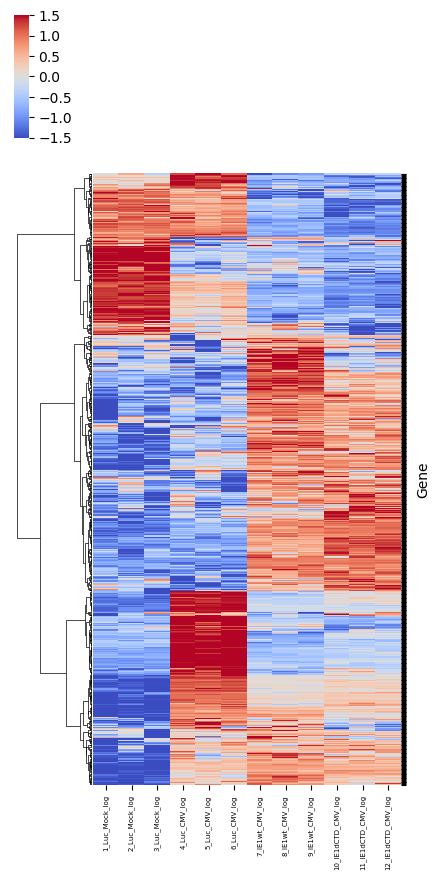

In [65]:
cg = sns.clustermap(hm_d, vmin=-1.5, vmax=1.5, cmap='coolwarm', col_cluster=False, z_score=0, figsize=(5,10), 
                    method='ward')
# cg.ax_row_dendrogram.set_visible(False)
# plt.setp(cg.ax_heatmap.get_yticklabels(), rotation=0)
cg.ax_heatmap.set_yticklabels([])
cg.ax_heatmap.set_ylabel("Gene")
plt.setp(cg.ax_heatmap.get_xticklabels(), fontsize=5)
plt.savefig(os.path.join(output_analysis_dir,"DE_genes_heatmap.png"), dpi=300)
plt.show()

In [28]:
from scipy.cluster.hierarchy import fcluster
k=6 # number of clusters
Z= cg.dendrogram_row.linkage # dendrogram data
clusts = fcluster(Z, k, criterion='maxclust')
cluster_df = hm_d.copy()
cluster_df.loc[:, "Cluster"]=np.array(clusts)
gene_dict={}
for i in range(1,k+1):
    gene_dict[i] = cluster_df[cluster_df["Cluster"]==i]
    gene_dict[i].to_csv(os.path.join(output_analysis_dir,"Cluster_"+str(i)+".csv"))
#     print len(cluster_df[cluster_df["Cluster"]==i])
    print "cluster {cluster_num}: {N} genes".format(cluster_num = i, N = len(cluster_df[cluster_df["Cluster"]==i]))
df.to_csv(os.path.join(output_analysis_dir,"All_genes.csv"))

cluster 1: 79 genes
cluster 2: 122 genes
cluster 3: 46 genes
cluster 4: 273 genes
cluster 5: 104 genes
cluster 6: 138 genes


Clust6 vs nonDE: MannwhitneyuResult(statistic=930265.5, pvalue=0.32599128308075914)


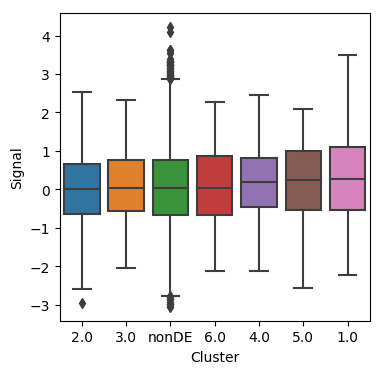

In [55]:
# Window ChIP signal around TSS of genes from differnt clusters:
joint = df["Signal"].to_frame().join(cluster_df)
joint["Cluster"][joint["Cluster"].isnull()]='nonDE'

medians_order = list(joint.groupby("Cluster").median().sort_values("Signal").index)
f, ax = plt.subplots(figsize=(4,4))
sns.boxplot(x="Cluster", y="Signal", data=joint, order=medians_order, ax=ax)
# plt.ylim([-1,10])
f = [joint[joint["Cluster"]==clust]["Signal"].values.flatten() for clust in range(1,6) + ['nonDE']] 
# print 'ANOVA:', stats.f_oneway(f[0], f[1], f[2], f[3], f[4], f[5], f[6])
# print 'KW:', stats.kruskal(f[0], f[1], f[2], f[3], f[4], f[5], f[6])
print 'Clust6 vs nonDE:', stats.mannwhitneyu(joint[joint["Cluster"]==6]["Signal"], joint[joint["Cluster"]=='nonDE']["Signal"])

#### Plot clusters separately

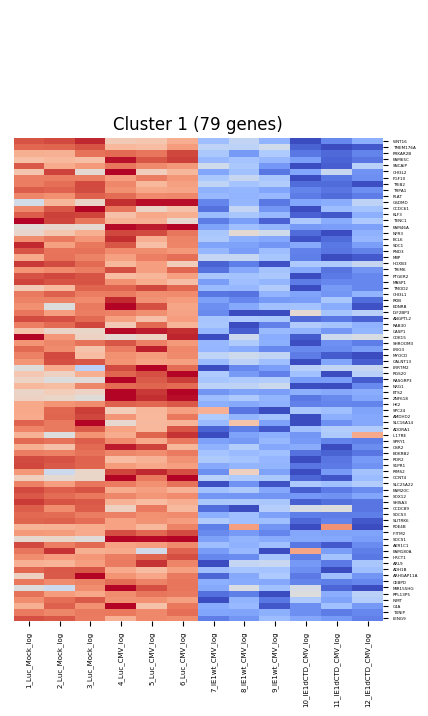

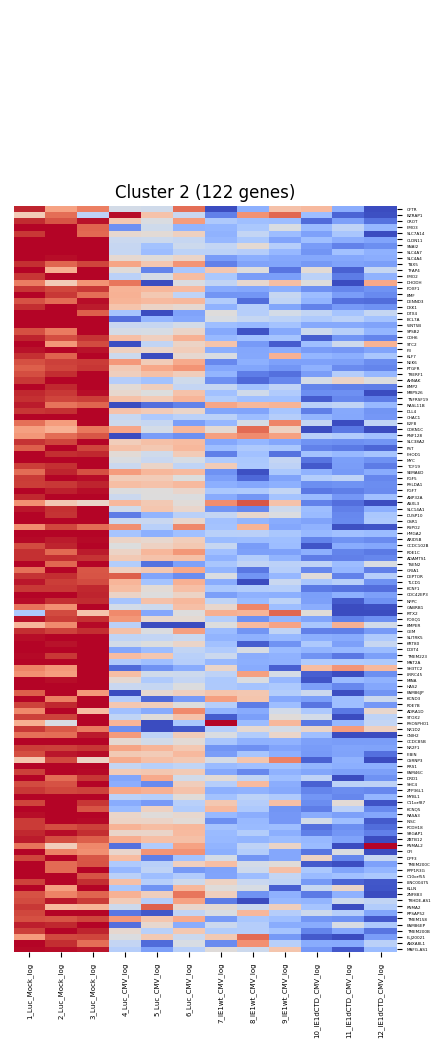

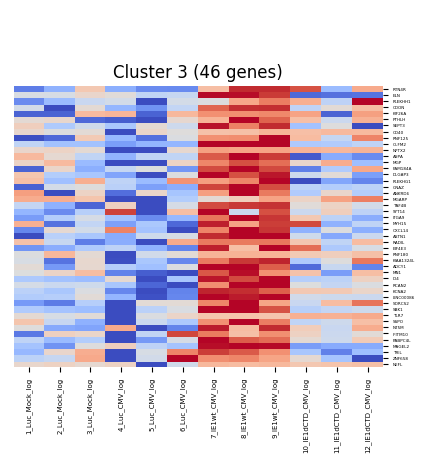

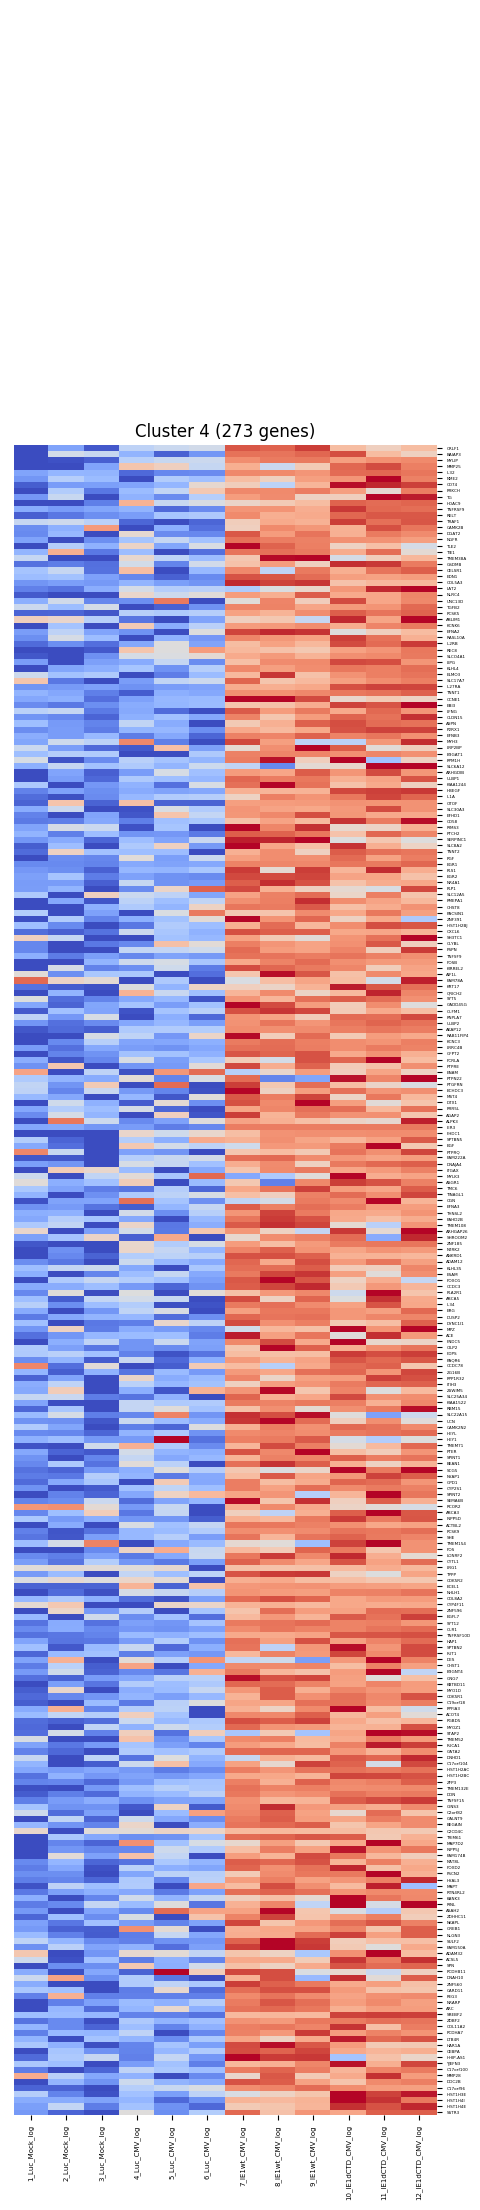

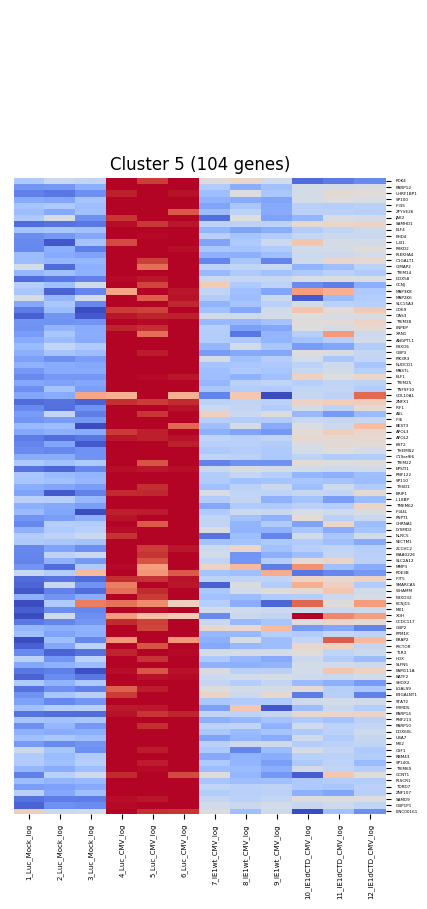

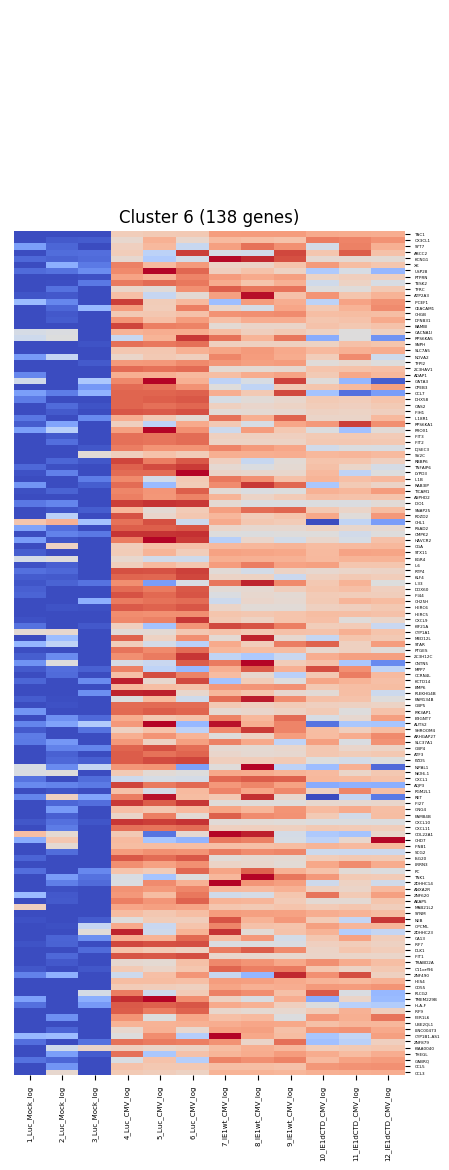

In [63]:
for clust in range (1,7):
    mat_len = len(gene_dict[clust])/10.
    cg = sns.clustermap(gene_dict[clust].drop("Cluster", axis=1), vmin=-1.5, vmax=1.5, 
                        cmap='coolwarm', col_cluster=False, row_cluster=False, z_score=0, figsize=(6,mat_len))
    cg.ax_row_dendrogram.set_visible(False)
    cg.cax.set_visible(False)
    cg.ax_heatmap.set_title("Cluster " + str(clust) + " ({N} genes)".format(N=len(gene_dict[clust])))
    cg.ax_heatmap.set_ylabel("")
    plt.setp(cg.ax_heatmap.get_xticklabels(), fontsize=5)
    plt.setp(cg.ax_heatmap.get_yticklabels(), rotation=0, fontsize=3)
    # cg.ax_heatmap.set_yticklabels([])
    plt.savefig(os.path.join(output_analysis_dir,"Separated_cluster_#{cluster}.png".format(cluster=clust)), dpi=800)
    plt.show()

### Analyze specific clusters:

In [34]:
def draw_spec_clust(clust_num):
#     clust_num = 5
    mat_len = len(gene_dict[clust_num])/10.
    sub_clust_d = gene_dict[clust_num].drop(["Cluster"], axis=1)
    cg = sns.clustermap(sub_clust_d, cmap='coolwarm', #vmin=-1.5, vmax=1.5,
                        col_cluster=False, row_cluster=True, z_score=0, 
                        figsize=(6,mat_len), method='ward')
    # cg.ax_row_dendrogram.set_visible(False)
    plt.setp(cg.ax_heatmap.get_yticklabels(), rotation=0, fontsize=3)
    cg.ax_heatmap.set_ylabel("Gene")
    cg.ax_heatmap.set_title("Cluster " + str(clust_num))

    # cg.ax_heatmap.set_yticklabels([])
    print "Cluster", str(clust_num)+":", (len(gene_dict[clust_num])), "genes"
    plt.savefig(os.path.join(output_analysis_dir,"Separated_cluster_" + str(clust_num) +"_reclustered.png"), dpi=800)
    plt.show()

Cluster 3: 46 genes


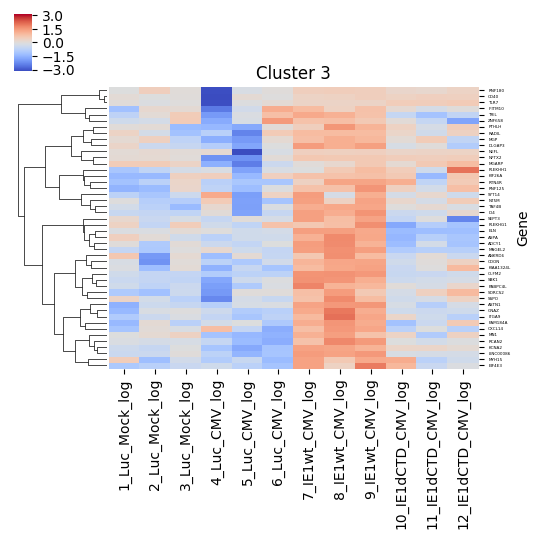

Cluster 5: 104 genes


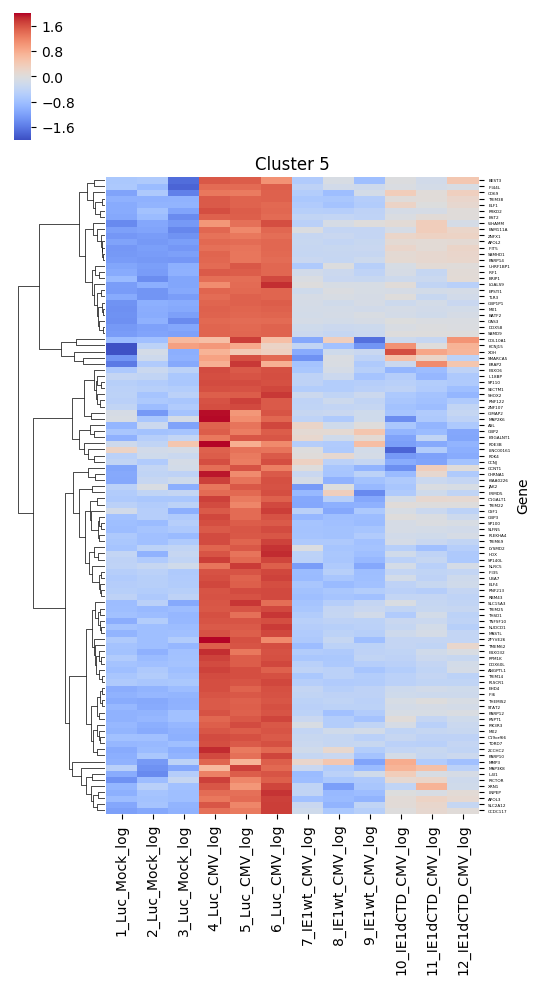

In [35]:
# draw specific clusters and recluster within:
draw_spec_clust(clust_num=3)
draw_spec_clust(clust_num=5)

### Focus on CLuster 5:

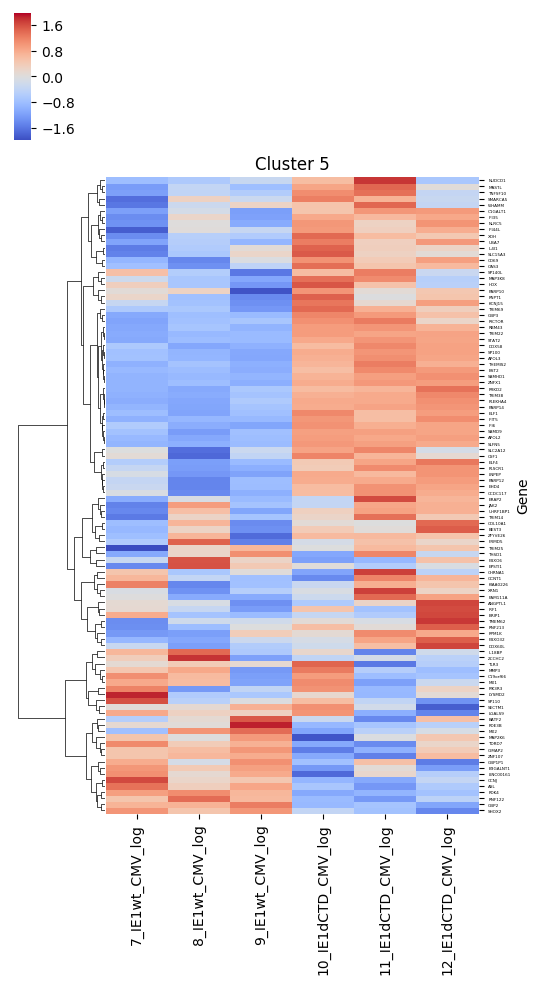

In [41]:
clust5 = gene_dict[5].drop(['Cluster', '1_Luc_Mock_log', '2_Luc_Mock_log', '3_Luc_Mock_log',
                            '4_Luc_CMV_log', '5_Luc_CMV_log', '6_Luc_CMV_log'], axis=1)
mat_len = len(clust5)/10.
cg = sns.clustermap(clust5, cmap='coolwarm', #vmin=-1.5, vmax=1.5,
                    col_cluster=False, row_cluster=True, z_score=0, 
                    figsize=(6,mat_len), method='ward')
# cg.ax_row_dendrogram.set_visible(False)
plt.setp(cg.ax_heatmap.get_yticklabels(), rotation=0, fontsize=3)
cg.ax_heatmap.set_ylabel("Gene")
cg.ax_heatmap.set_title("Cluster 5")

# cg.ax_heatmap.set_yticklabels([])
# print "Cluster", str(clust_num)+":", (len(gene_dict[clust_num])), "genes"
# plt.savefig(os.path.join(output_analysis_dir,"Separated_cluster_" + str(clust_num) +"_reclustered.png"), dpi=800)
plt.show()

cluster 1: 77 genes
cluster 2: 11 genes
cluster 3: 16 genes


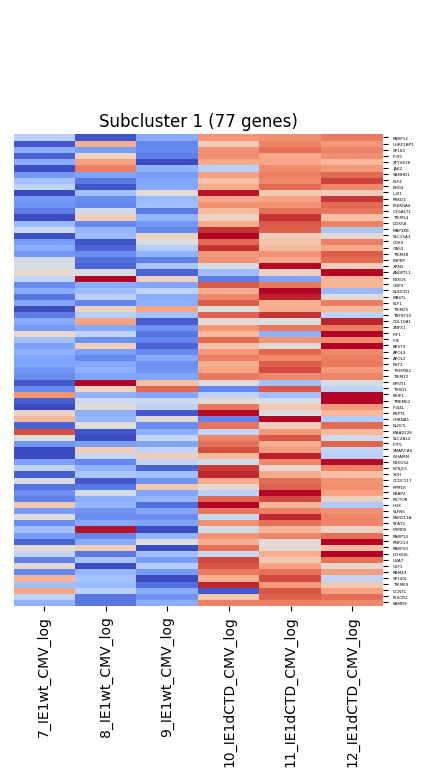

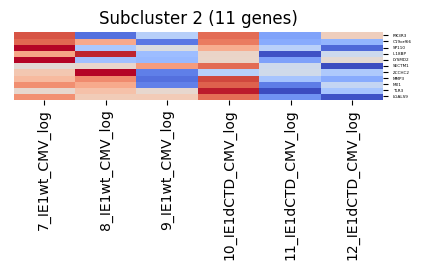

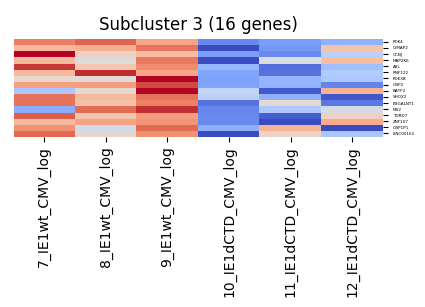

In [46]:
# Subcluster 5 across IE1wt and IE1dCTD only
k=3 # number of clusters
Z= cg.dendrogram_row.linkage # dendrogram data
clusts = fcluster(Z, k, criterion='maxclust')
clust5.loc[:, "Cluster"]=np.array(clusts)
subclust_dict={}
for i in range(1,k+1):
    subclust_dict[i] = clust5[clust5["Cluster"]==i]
    subclust_dict[i].to_csv(os.path.join(output_analysis_dir,"Sub_cluster_"+str(i)+".csv"))
    print "cluster {cluster_num}: {N} genes".format(cluster_num = i, N = len(sub_clust_d[sub_clust_d["Cluster"]==i]))

for clust in range (1,4):
    mat_len = len(subclust_dict[clust])/10.
    h = sns.clustermap(subclust_dict[clust].drop("Cluster", axis=1), vmin=-1.5, vmax=1.5, 
                        cmap='coolwarm', col_cluster=False, row_cluster=False, z_score=0, figsize=(6,mat_len))
    h.ax_row_dendrogram.set_visible(False)
    h.cax.set_visible(False)
    h.ax_heatmap.set_title("Subcluster " + str(clust) + " ({N} genes)".format(N=len(subclust_dict[clust])))
    h.ax_heatmap.set_ylabel("")
    plt.setp(h.ax_heatmap.get_yticklabels(), rotation=0, fontsize=3)
    # cg.ax_heatmap.set_yticklabels([])
    plt.savefig(os.path.join(output_analysis_dir,"Separated_subcluster_#{cluster}_of_c5.png".format(cluster=clust)), dpi=800)
    plt.show()    

In [48]:
# # Subcluster across all samples
# k=3 # number of clusters
# Z= cg.dendrogram_row.linkage # dendrogram data
# clusts = fcluster(Z, k, criterion='maxclust')
# sub_clust_d.loc[:, "Cluster"]=np.array(clusts)
# subclust_dict={}
# for i in range(1,k+1):
#     subclust_dict[i] = sub_clust_d[sub_clust_d["Cluster"]==i]
#     subclust_dict[i].to_csv(os.path.join(output_analysis_dir,"Sub_cluster_"+str(i)+".csv"))
#     print "cluster {cluster_num}: {N} genes".format(cluster_num = i, N = len(sub_clust_d[sub_clust_d["Cluster"]==i]))
# for clust in range (1,4):
#     mat_len = len(subclust_dict[clust])/10.
#     h = sns.clustermap(subclust_dict[clust].drop("Cluster", axis=1), vmin=-1.5, vmax=1.5, 
#                         cmap='coolwarm', col_cluster=False, row_cluster=False, z_score=0, figsize=(6,mat_len))
#     h.ax_row_dendrogram.set_visible(False)
#     h.cax.set_visible(False)
#     h.ax_heatmap.set_title("Subcluster " + str(clust) + " ({N} genes)".format(N=len(subclust_dict[clust])))
#     h.ax_heatmap.set_ylabel("")
#     plt.setp(h.ax_heatmap.get_yticklabels(), rotation=0, fontsize=3)
#     # cg.ax_heatmap.set_yticklabels([])
#     plt.savefig(os.path.join(output_analysis_dir,"Separated_subcluster_#{cluster}_of_c6.png".format(cluster=clust)), dpi=800)
#     plt.show()

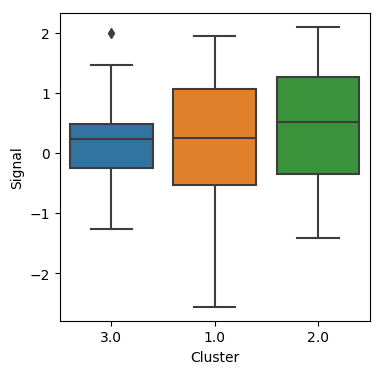

In [50]:
joint = df["Signal"].to_frame().join(sub_clust_d)
# joint["Cluster"][joint["Cluster"].isnull()]='nonDE'

medians_order = list(joint.groupby("Cluster").median().sort_values("Signal").index)
f, ax = plt.subplots(figsize=(4,4))
sns.boxplot(x="Cluster", y="Signal", data=joint, order=medians_order, ax=ax)
cl1_sig = joint[joint["Cluster"]==1]["Signal"]
cl2_sig = joint[joint["Cluster"]==2]["Signal"]
cl3_sig = joint[joint["Cluster"]==3]["Signal"]
cl4_sig = joint[joint["Cluster"]==4]["Signal"]
cl5_sig = joint[joint["Cluster"]==5]["Signal"]
# cl6_sig = joint[joint["Cluster"]=='nonDE']["Signal"]
# stats.kruskal(cl1_sig,cl2_sig,cl3_sig,cl4_sig,cl5_sig,cl6_sig)
# stats.kruskal([cl2_sig,cl3_sig,cl4_sig)
# stats.mannwhitneyu(cl3_sig, cl1_sig)

### Examine intersections (venn diagrams):

#### 1) ChIP high AND up/down-regulated by CTD (i.e. logFC IE1/dCTD>0 or <0)

In [13]:
binding_z_thr = 1 # Threshold Z-score for defining positive binding
fold_thr=1.5 # Threshold fold-change in expression (up/down regulation)

bound = df[df["Signal"] >= binding_z_thr]
bound_down = bound[bound["IE1_mean"] * fold_thr < bound["IE1dCTD_mean"] ]
bound_up = bound[bound["IE1_Logmean"] > bound["IE1dCTD_Logmean"] * fold_thr]

print "Highly bound and down-regulated in a CTD-dependent manner:", len(bound_down)
print "Highly bound and up-regulated in a CTD-dependent manner:", len(bound_up)

bound_down["Gene"].to_csv(os.path.join(output_analysis_dir,"bound_downreg.csv"))
bound_up["Gene"].to_csv(os.path.join(output_analysis_dir,"bound_upreg.csv"))

Highly bound and down-regulated in a CTD-dependent manner: 163
Highly bound and up-regulated in a CTD-dependent manner: 151


In [14]:
# bound_down.sort_values(by="Signal").tail()

#### 2) ChIP low (depleted) AND up/down-regulated by CTD (i.e. logFC IE1/dCTD>0 or <0)

In [15]:
binding_z_thr = -1 # Threshold Z-score for defining binding depletion
fold_thr=1.5 # Threshold fold-change in expression (up/down regulation)

unbound = df[df["Signal"] <= binding_z_thr]
unbound_down = unbound[unbound["IE1_mean"] * fold_thr < unbound["IE1dCTD_mean"] ]
unbound_up = unbound[unbound["IE1_Logmean"] > unbound["IE1dCTD_Logmean"] * fold_thr]

print "Lowly bound and down-regulated in a CTD-dependent manner:", len(unbound_down)
print "Lowly bound and up-regulated in a CTD-dependent manner:", len(unbound_up)

unbound_down["Gene"].to_csv(os.path.join(output_analysis_dir,"unbound_downreg.csv"))
unbound_up["Gene"].to_csv(os.path.join(output_analysis_dir,"unbound_upreg.csv"))

Lowly bound and down-regulated in a CTD-dependent manner: 46
Lowly bound and up-regulated in a CTD-dependent manner: 71


## Examination of ChIP signal for different expression behaviours:

In [23]:
df = df.sort_values(by="Gene")

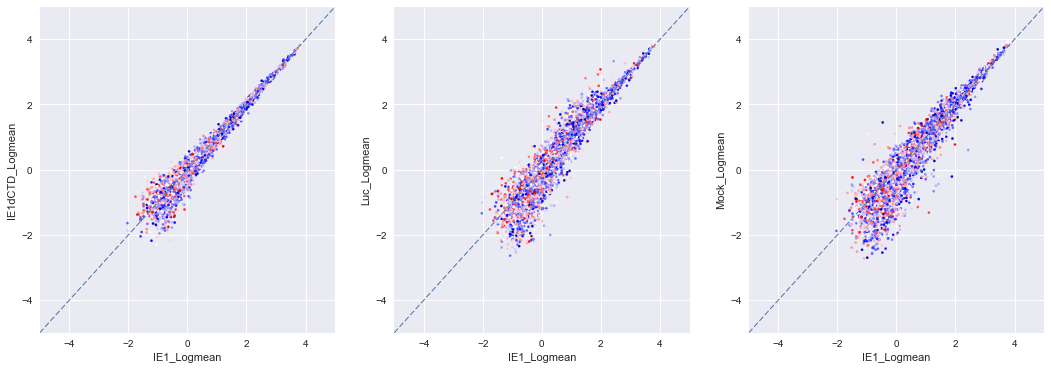

In [25]:
f, axs = plt.subplots(ncols=3, nrows=1, figsize=(18,6))
for i, feat in enumerate(["IE1dCTD_Logmean", "Luc_Logmean", "Mock_Logmean"]):
    cm = axs[i].scatter(df["IE1_Logmean"], df[feat], alpha=1, s=5, c=df["Signal"], cmap="seismic")
    axs[i].plot([-5,5], [-5,5], linestyle='--', linewidth=1)
    axs[i].set_ylabel(feat)
    axs[i].set_xlabel("IE1_Logmean")
    # f.colorbar(cm)
    axs[i].set_xlim([-5,5])
    axs[i].set_ylim([-5,5])
plt.show()

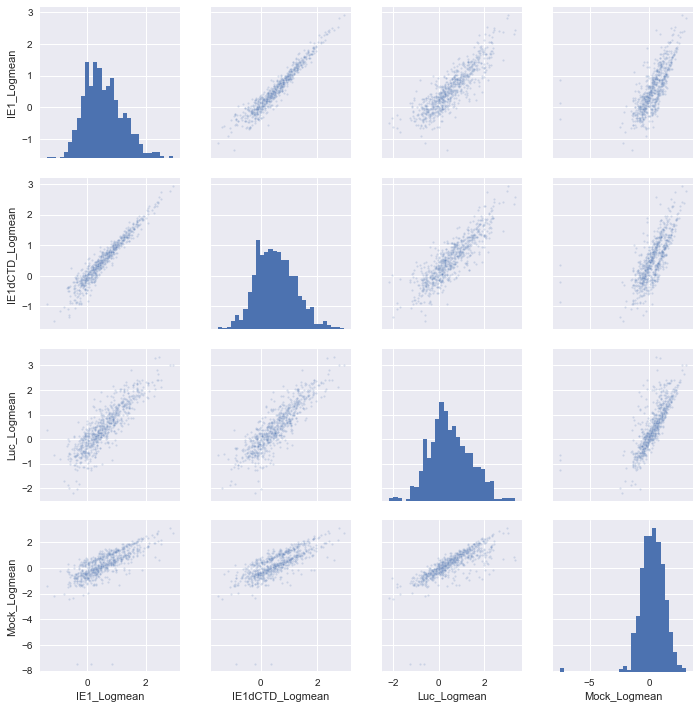

In [26]:
sns.pairplot(d[log_mean_exp_cols], plot_kws={'alpha':0.2, 's':5}, diag_kws={'bins':30})

In [80]:
d = df.copy()
d = standardize_df(d, column='Signal')# 'IE1_mean', 'IE1dCTD_mean','Luc_mean', 'Mock_mean']])
Thresh_perc = 5
High_binding = np.percentile(d["Signal"], 100-Thresh_perc)
Low_binding = np.percentile(d["Signal"], Thresh_perc)
d.loc[d["Signal"]>=High_binding, "Binding"] = "high"
# d.loc[(d["Signal"]<High_binding) & (d["Signal"]>Low_binding), "Binding"] = "medium"
d.loc[d["Signal"]<=Low_binding, "Binding"] = "low"

In [81]:
dfs = []
for g in ["IE1_Logmean", "IE1dCTD_Logmean", "Luc_Logmean", "Mock_Logmean"]:
    d1 = d.loc[:, [g, "Binding"]]
    d1.loc[:, "log_exp"] = d1[g]
    d1.drop(g, axis=1, inplace=True)
    d1.loc[:, "Condition"] = g
    dfs.append(d1)
cdf = pd.concat(dfs)

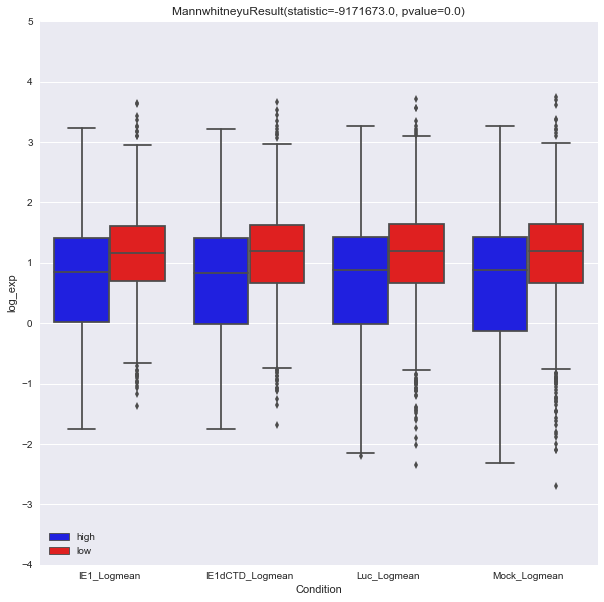

In [83]:
f,ax = plt.subplots(figsize=(10,10))
sns.boxplot(x="Condition", y="log_exp", hue="Binding", data=cdf,  palette=['b','r'], ax=ax)
ax.set_ylim([-4,5])
plt.legend(loc=3)
plt.title(stats.mannwhitneyu(cdf[cdf["Binding"]=='high'], cdf[cdf["Binding"]=='low'])) # compare exp of high to low bound
plt.show()

In [120]:
def box_BindingOfDE(df, comparison):
    comp = df[df["Comparison"]==comparison]
    up_genes = comp[(comp["pass"]=="yes") & (comp["Direction"]=="up")]
    down_genes = comp[(comp["pass"]=="yes") & (comp["Direction"]=="down")]
    non_de_genes = comp[comp["pass"]=="no"]
    
    plt.subplots(figsize=(2,5))
    plt.boxplot([up_genes["Signal"], down_genes["Signal"]])
    plt.xticks([1,2],["Up-Reg", "Down-Reg"])
    plt.ylabel("Binding signal")
    plt.title(stats.mannwhitneyu(up_genes["Signal"], down_genes["Signal"]))
    plt.show()

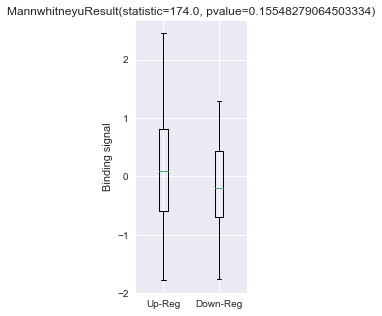

In [121]:
box_BindingOfDE(df, comparison ="IE1wt_CMV_vs_IE1dCTD_CMV")

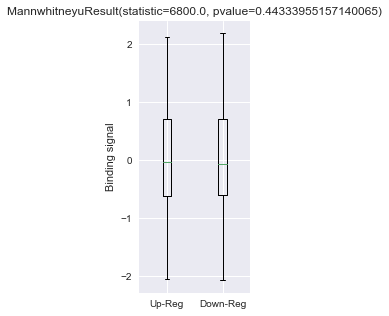

In [122]:
box_BindingOfDE(df, comparison ="IE1wt_CMV_vs_Luc_Mock")

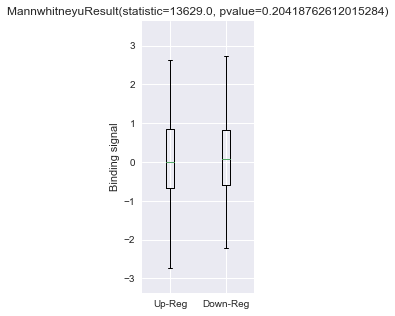

In [123]:
box_BindingOfDE(df, comparison ="IE1dCTD_CMV_vs_Luc_Mock")

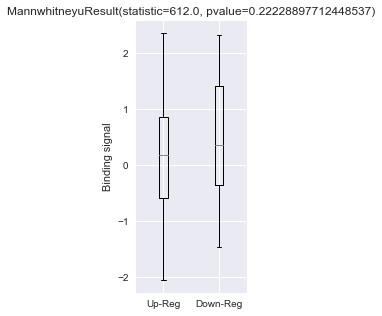

In [124]:
box_BindingOfDE(df, comparison ="Luc_CMV_vs_Luc_Mock")

In [68]:
import deeptools

In [71]:
import deeptools.countReadsPerBin


In [75]:
deeptools.countReadsPerBin.

<module 'deeptools.countReadsPerBin' from '/Users/erankotler/anaconda/lib/python2.7/site-packages/deeptools/countReadsPerBin.pyc'>